### Imports

In [19]:
import zipfile
import os
from tqdm import tqdm
import numpy as np
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import copy

### Load Data

Unzip Data

In [20]:
with zipfile.ZipFile('all_alignments_trimmed.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

Find FASTA Files

In [21]:
path = './Data/all_alignments_trimmed'
fasta_files = [f for f in os.listdir(path) if f.endswith('.fasta')]

Get Phyla for Each Species

In [22]:
species_dict = {}

with open('species_group.txt', 'r') as file:
    lines = file.readlines()

    for line in lines:
        species, phylum = line.split('>')[0].strip(), line.split('>')[1].strip()
        species_dict[species.strip()] = phylum

Function to Get Sequences From FASTA File as Dict

In [23]:
species_counts = {}
gene_counts = {}

# returns a dictionary object with sequence names as keys and sequences as values
def get_sequences(fasta_file):
    with open(os.path.join(path, fasta_file), 'r') as file:
        sequences = {}
        current_seq_name = None
        current_sequence = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # start of a new sequence
                if current_seq_name:  # save the previous sequence
                    sequences[current_seq_name] = ''.join(current_sequence)
                    species_counts[current_seq_name] = species_counts.get(current_seq_name, 0) + 1
                current_seq_name = line[1:]  # save the sequence name (exclude '>')
                current_sequence = []  # reset the sequence buffer
            else:
                current_sequence.append(line)  # collect sequence data
        if current_seq_name:  # save the last sequence in the file
            sequences[current_seq_name] = ''.join(current_sequence)
    gene_counts[fasta_file] = len(sequences)
    species_counts["TOTAL GENES"] = species_counts.get("TOTAL GENES", 0) + 1
    return sequences

Dictionary of Dictionaries Containing Sequences for Every Gene

In [24]:
gene_sequences = {}
for fasta_file in fasta_files:
    sequences = get_sequences(fasta_file)
    gene_name = fasta_file.split('_')[0]
    gene_sequences[gene_name] = sequences

Save the Unique Species and their Counts

In [25]:
with open('species_count.txt', 'w') as f:
    for species, count in sorted(species_counts.items(), key=lambda x: x[1], reverse=True):
        f.write(f'{species}\t{count}\n')

Gets the 25 species that allow for the largest overlap with the seed species (greedy approach)

In [26]:
# seed species for the tree
needed_species = ["Xenoturbella bocki@211205", "Pediculus humanus@282015", "Leucosolenia complicata@292502"]

for _ in range(25 - len(needed_species)):
    temp_species_counts = {}
    for gene_name, sequences in gene_sequences.items():
        skip_gene = False
        for species in needed_species:
            if species not in sequences.keys():
                skip_gene = True
                break
        if skip_gene:
            continue
        for count_species in sequences.keys():
            if count_species in needed_species:
                continue
            temp_species_counts[count_species] = temp_species_counts.get(count_species, 0) + 1
    sorted_list = sorted(temp_species_counts.items(), key=lambda x: x[1], reverse=True) # the species overlapping the most with the seed species
    needed_species.append(sorted_list[0][0]) # add to seed species

print(f'25 species to include: {needed_species}')

# removes all data that is not the relevant species / genes and tallies the number of genes that are left
num_genes = 0
genes_to_delete = []
for gene_name, sequences in gene_sequences.items():
    skip_gene = False
    relevant_count = 0
    species_to_delete = []
    for species in sequences.keys():
        if species in needed_species:
            relevant_count += 1
        else:
            species_to_delete.append(species)
    for species in species_to_delete:
        del sequences[species]
    if relevant_count != len(needed_species):
        genes_to_delete.append(gene_name)
        continue
    num_genes += 1
print(f'Remaining genes: {num_genes} of {species_counts["TOTAL GENES"]}')

for gene_name in genes_to_delete:
    del gene_sequences[gene_name]

with open('included_species.txt', 'w') as f:
    for species in needed_species:
        f.write(f'{species} >{species_dict[species]}\n')



25 species to include: ['Xenoturbella bocki@211205', 'Pediculus humanus@282015', 'Leucosolenia complicata@292502', 'Homo sapiens@338256', 'Balanoglossus cf._aurantica_JTC2014@323706', 'Saccoglossus kowalevskii@331685', 'Strongylocentrotus purpuratus@313517', 'Patiria miniata@327719', 'Asterias forbesi@321609', 'Sclerodactyla briareus@321628', 'Stichopus japonicus@291573', 'Oxycomanthus japonicus@313265', 'Echinarachnius parma@296875', 'Harrimaniidae sp._n._clade_1_JTC2014@284051', 'Paratomella rubra@308417', 'Isodiametra pulchra@306835', 'Hofstenia miamia@291452', 'Loligo pealei@317280', 'Branchiostoma floridae@306508', 'Stomolophus meleagris@295611', 'Ptychodera bahamensis@271470', 'Ophiocoma echinata@285659', 'Symsagittifera roscoffensis@284582', 'Lottia gigantea@319634', 'Acropora cervicornis@299639']
Remaining genes: 290 of 1173


### Concat All Genes

For approaches using concatenated genes, this combines all the genes for the 25 relevant species into one protein sequence per species

In [27]:
all_genes_sequences = {}
for gene_name, sequences in gene_sequences.items():
    for species, sequence in sequences.items():
        all_genes_sequences[species] = all_genes_sequences.get(species, '') + sequence

### Calculate Distance Matrix

In [43]:
scoring_matrices = {}
for i in ['BLOSUM62', 'PAM250', 'BLOSUM45']:
    matrix = {}
    with open(f'{i}.txt', 'r') as f:
        lines = f.readlines()[1:]
        keys = lines[0].split()
        keys[-1] = '-'
        for j, line in enumerate(lines[1:]):
            matrix[keys[j]] = {k : int(v) for (k,v) in zip(keys, line.split()[1:])}
    scoring_matrices[i] = matrix

def calculate_distance(seq1, seq2, score_matrix):
    score = 0
    for i in range(len(seq1)):
        a = '-' if seq1[i] == '?' else seq1[i]
        b = '-' if seq2[i] == '?' else seq2[i]
        score -= scoring_matrices[score_matrix][a][b]
    return score

In [44]:
def get_distance_matrix(sequences, score_matrix):
    distance_matrix = {}
    for seq1_name, seq1 in sequences.items():
        distance_matrix[seq1_name] = {}
        for seq2_name, seq2 in sequences.items():
            distance_matrix[seq1_name][seq2_name] = calculate_distance(seq1, seq2, score_matrix)
    return distance_matrix

In [45]:
def get_distance_matrices_all(score_matrix):
    distance_matrices = {}
    print('Calculating individual gene distance matrices')
    for gene_name, sequences in tqdm(gene_sequences.items()):
        distance_matrices[gene_name] = get_distance_matrix(sequences, score_matrix)

    print('Calculating concatenated genes distance matrix')
    all_gene_distance_matrix = get_distance_matrix(all_genes_sequences, score_matrix)

    return distance_matrices, all_gene_distance_matrix

### Perform Neighbor Joining

In [46]:
def min_S_value(D, u):
    m = len(D)
    min_S, min_i, min_j = float("inf"), -1, -1
    for k in D:
        for l in D[k]:
            if l != k:
                crit = (m - 2) * D[k][l] - u[k] - u[l]
                if crit < min_S:
                    min_S = crit
                    min_i = k
                    min_j = l
    return (min_i, min_j)

def neighbor_join(D):
    D = copy.deepcopy(D)
    T = {} 
    clusters = []  # List of clusters
    r = len(D)
    new_node = r
    species = set(D.keys())

    # Initialize clusters from D
    current_clusters = {k: [k] for k in D}

    while len(D) > 2:
        u = {k: sum(D[k].values()) for k in D}
        i, j = min_S_value(D, u)

        r = new_node
        new_node += 1

        if i not in T:
            T[i] = {}
        if j not in T:
            T[j] = {}
        T[r] = {}
        T[r][i] = 0.5 * (D[i][j] + (u[i] - u[j]) / (len(D) - 2))
        T[i][r] = T[r][i]
        T[r][j] = 0.5 * (D[i][j] + (u[j] - u[i]) / (len(D) - 2))
        T[j][r] = T[r][j]

        # Update clusters: combine the clusters of i and j
        current_clusters[r] = current_clusters[i] + current_clusters[j]
        clusters.append(current_clusters[r])  # Add the new cluster to the list

        new_dist = {}
        for m in D:
            if m != i and m != j:
                new_dist[m] = 0.5 * (D[i][m] + D[j][m] - D[i][j])  
                D[m][r] = new_dist[m]

        D[r] = new_dist

        del D[i]
        del D[j]
        for k in D:
            if i in D[k]:
                del D[k][i]
            if j in D[k]:
                del D[k][j]

        del current_clusters[i]
        del current_clusters[j]

    extra = list(D.keys())
    i, j = extra[0], extra[1]
    if i not in T:
        T[i] = {}
    if j not in T:
        T[j] = {}
    T[i][j] = D[i][j]
    T[j][i] = D[i][j]

    # Add the final cluster
    clusters.append(current_clusters[i] + current_clusters[j])

    #change to cluster to set for returning
    ret = []
    for cluster in clusters:
        ret.append(set(cluster))
        ret = sorted(ret, key=len) #sort by length

    return T, ret,species

In [47]:
def generate_trees(score_matrix):
    distance_matrices, all_gene_distance_matrix = get_distance_matrices_all(score_matrix)
    print('Generating trees with neighbor joining')
    trees = {}
    genes = list(gene_sequences.keys())
    for gene in genes:
        trees[gene] = neighbor_join(distance_matrices[gene])        

    all_genes_tree = neighbor_join(all_gene_distance_matrix)

    return trees, all_genes_tree

### Creating Consensus Tree (Greedy)

In [48]:
def get_consensus_tree(trees):
    #first count all clusters
    print('Generating consensus tree')
    cluster_counts = {}
    for gene in list(gene_sequences.keys()):
        clusters = trees[gene][1]
        for c in clusters:
            c = frozenset(c)
            if c in cluster_counts.keys():
                cluster_counts[c] += 1
            else:
                cluster_counts[c] = 1
    cluster_counts = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True) # sort clusters from most common to least common

    #then add into tree, not added if it conflicts with current tree
    consensus_clusters = []
    for c in cluster_counts:
            cluster = c[0]
            Add = True
            for s in consensus_clusters:
                if not (s.issubset(cluster) or cluster.issubset(s) or s.isdisjoint(cluster)):
                    Add = False
            if Add:
                consensus_clusters.append(cluster)

    return consensus_clusters

### Visualize Tree

Gets the character matrix for graphing from neighbor joined clusters

In [ ]:
def get_character_matrix(clusters):
    root = "Leucosolenia complicata@292502"
    character_clusters = []
    test = []
    for c in clusters:
        if not root in c:
            character_clusters.append(c)
        else:
            test.append(c)

    rows = len(needed_species)
    cols = len(character_clusters)
    mat = [[0 for _ in range(cols)] for _ in range(rows)]
    for r in range(rows):

        for c in range(cols):

            if needed_species[r] in character_clusters[c]:

                mat[r][c] = 1
    return mat

Builds the tree using character matrix and displays plot

In [50]:
def build_tree(clusters, title=None):
    character_traits = get_character_matrix(clusters)
    for i in range(len(character_traits)):
        for j in range(len(character_traits)):
            if i == j:
                character_traits[i].append(1)
            else:
                character_traits[i].append(0)
        character_traits[i].append(1)

    character_matrix = {}

    count = 0
    phyla = set()
    with open('included_species.txt', 'r') as f:
        for line in f:
            species, phylum = line.strip().split(' >')
            character_matrix[species.split('@')[0] + f'<{phylum}'] = character_traits[count]
            count += 1
            phyla.add(phylum)

    phyla_color = {
        'Ecdysozoa': 'red',
        'Lophotrochozoa': 'darkblue',
        'Hemichordata': 'green',
        'Echinodermata': 'dodgerblue',
        'Porifera': 'purple',
        'Chordata': 'orange',
        'Xenacoelomorpha': 'brown',
        'Cnidaria': 'fuchsia',
    }

    species = list(character_matrix.keys())
    matrix = []

    for i, species1 in enumerate(species):
        row = []
        for j, species2 in enumerate(species):
            if j <= i:
                distance = sum(c1 != c2 for c1, c2 in zip(character_matrix[species1], character_matrix[species2]))
                row.append(distance)
        matrix.append(row)

    distance_matrix = DistanceMatrix(species, matrix)

    constructor = DistanceTreeConstructor()
    tree = constructor.nj(distance_matrix)
    tree.root_with_outgroup("Leucosolenia complicata<Porifera")

    label_colors = {}

    for clade in tree.find_clades(): 
        if not clade.is_terminal(): 
            clade.name = None
        else:
            phylum = clade.name.split('<')[1]
            clade.name = clade.name.split('<')[0]
            label_colors[clade.name] = phyla_color[phylum]


    fig = plt.figure(figsize=(12, 8))
    axes = fig.add_subplot(1, 1, 1)

    def color_label(node):
        return label_colors[node]

    Phylo.draw(tree, axes=axes, do_show=False, label_colors=color_label)

    # Adding the legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=phylum) for phylum, color in phyla_color.items()]
    plt.legend(handles=legend_elements, title='Phyla', loc='upper left')

    plt.title(title)

    plt.show()

### Bring Everything Together and Display Trees

Calculating individual gene distance matrices


100%|██████████| 290/290 [00:07<00:00, 40.56it/s]


Calculating concatenated genes distance matrix
Generating trees with neighbor joining
Generating consensus tree


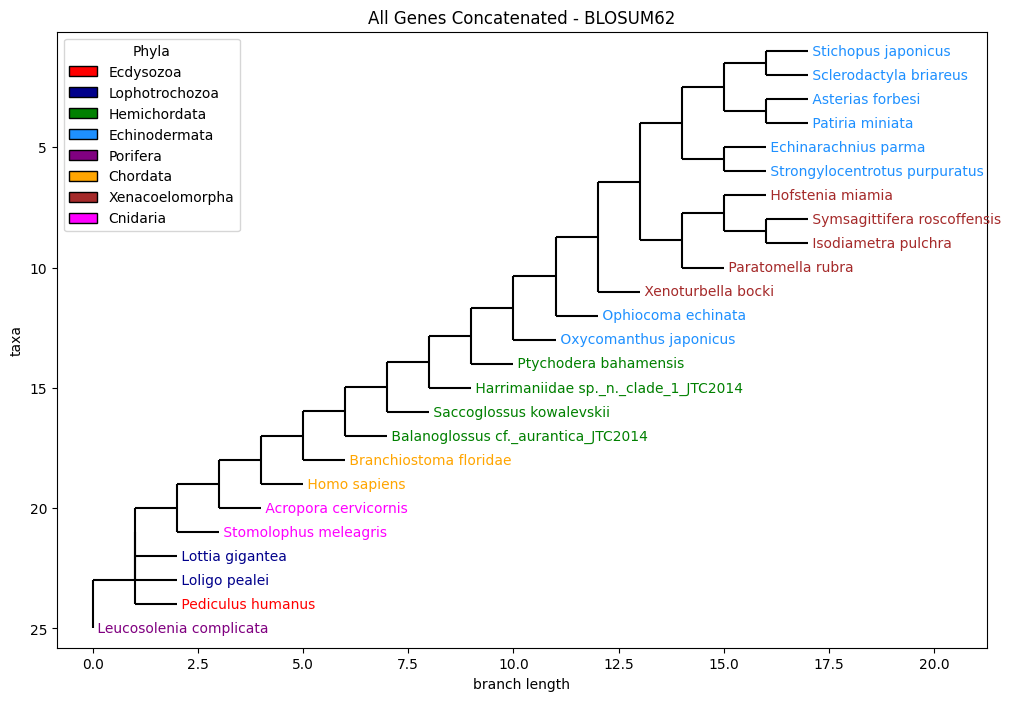

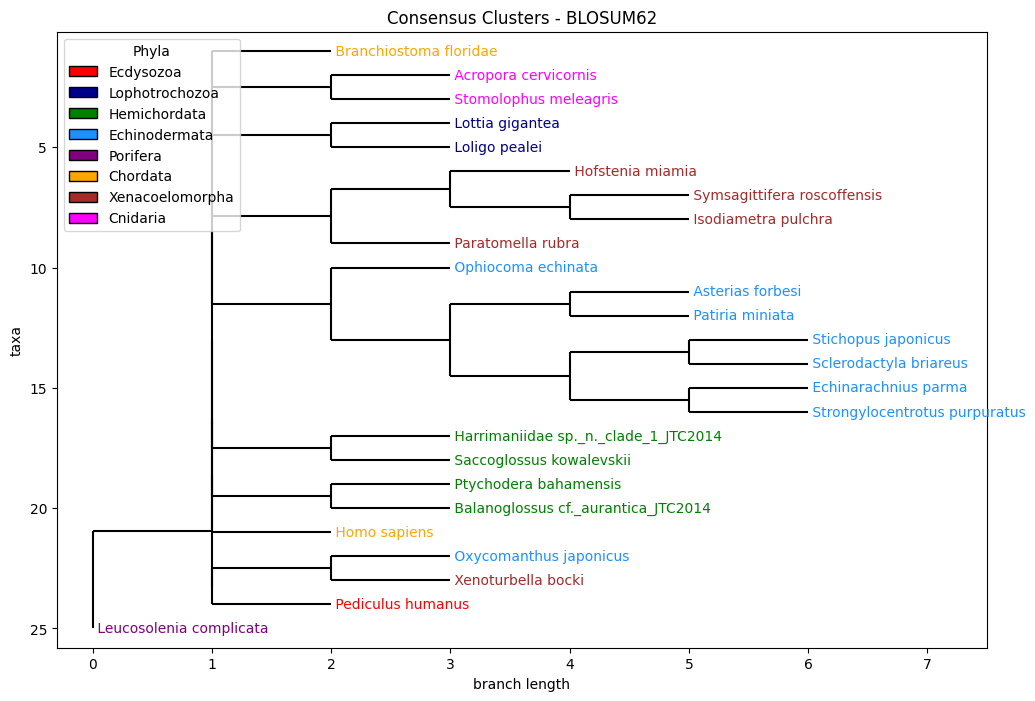

In [51]:
# Choose from 'BLOSUM45', 'BLOSUM62', 'PAM250'
scoring_matrix = 'BLOSUM62'
trees, all_genes_tree = generate_trees(scoring_matrix)
consensus_clusters = get_consensus_tree(trees)

build_tree(all_genes_tree[1], title=f'All Genes Concatenated - {scoring_matrix}')
build_tree(consensus_clusters, title=f'Consensus Clusters - {scoring_matrix}')